# FNO Time Evolution Operator for 2D Cylinder Flow

This notebook implements a Fourier Neural Operator (FNO) as a neural time integrator for 2D cylinder flow using the CFDBench dataset.

**Learning Objective**: Learn the discrete Navier-Stokes flow map:
$$u^{t+\Delta t}(x) = G_\theta(u^t(x), BC, \nu, \rho, geometry)$$

The model is trained as a one-step predictor and advanced autoregressively.


In [38]:
import os
# CRITICAL: Set environment variable BEFORE importing torch
# This enables automatic CPU fallback for unsupported MPS operations (like FFT)
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from typing import Tuple, List, Dict
import sys

# Add parent directory to path to import data loader
sys.path.append(str(Path.cwd().parent))
from data_handle.data import get_cylinder_auto_datasets

# Set device - prioritize Apple's MPS (Metal Performance Shaders) for Apple Silicon
# With PYTORCH_ENABLE_MPS_FALLBACK=1, unsupported ops (like FFT) will automatically use CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
    fft_device = torch.device('cpu')  # FFT operations must use CPU
    print("Using device: Apple Metal Performance Shaders (MPS)")
    print("Note: PYTORCH_ENABLE_MPS_FALLBACK=1 enabled")
    print("      FFT operations will automatically fall back to CPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    fft_device = torch.device('cuda')
    print("Using device: CUDA")
else:
    device = torch.device('cpu')
    fft_device = torch.device('cpu')
    print("Using device: CPU")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Simple train/test split function (replaces sklearn)
def train_test_split(*arrays, test_size=0.3, random_state=None, shuffle=True):
    """Simple train/test split without sklearn dependency
    Compatible with sklearn's train_test_split API"""
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    n_test = int(n_samples * test_size)
    indices = np.arange(n_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    result = []
    for array in arrays:
        if isinstance(array, (list, tuple)):
            train_data = [array[i] for i in train_indices]
            test_data = [array[i] for i in test_indices]
        else:
            train_data = array[train_indices]
            test_data = array[test_indices]
        result.extend([train_data, test_data])
    
    return tuple(result)


Using device: Apple Metal Performance Shaders (MPS)
Note: PYTORCH_ENABLE_MPS_FALLBACK=1 enabled
      FFT operations will automatically fall back to CPU


## 1. Data Loading with JSON Metadata

Load data from different boundary condition subsets and include JSON metadata.


In [39]:
# Load data from BC subset (boundary conditions)
DATA_DIR = Path("../../../")
bc_train_data, bc_dev_data, bc_test_data = get_cylinder_auto_datasets(
    data_dir=DATA_DIR,
    subset_name="bc",
    norm_props=True,
    norm_bc=True,
    case_fraction=1.0,  # Use all cases
    load_splits=["train", "dev", "test"]
)

# Combine train and dev for 70/30 split
all_cases = []
all_u_data = []
all_v_data = []
all_params = []

if bc_train_data:
    all_cases.extend(bc_train_data.case_names)
    all_u_data.extend(bc_train_data.u_data)
    all_v_data.extend(bc_train_data.v_data)
    all_params.extend(bc_train_data.case_params)

if bc_dev_data:
    all_cases.extend(bc_dev_data.case_names)
    all_u_data.extend(bc_dev_data.u_data)
    all_v_data.extend(bc_dev_data.v_data)
    all_params.extend(bc_dev_data.case_params)

print(f"Total cases loaded: {len(all_cases)}")
print(f"Data shape: {all_u_data[0].shape}")
print(f"Sample parameters: {all_params[0]}")



Searching in subset: bc
Data directory: /Users/thaddeusli/Desktop/PH188CFD
==== Number of cases in different splits (Subset) ====
train: 40, dev: 5, test: 5
  [Loader]: Processing data for split 'train' from 40 case(s).
    ⚠ case0043: Truncated from 1000 to 620 timesteps
    ✓ case0043: u.npy shape (620, 64, 64), v.npy shape (620, 64, 64), params: {'vel_in': 4.3999999999999995, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min': -0.06, 'x_max': 0.16, 'y_min': -0.06, 'y_max': 0.06}
    ⚠ case0001: Truncated from 1000 to 620 timesteps
    ✓ case0001: u.npy shape (620, 64, 64), v.npy shape (620, 64, 64), params: {'vel_in': 0.2, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min': -0.06, 'x_max': 0.16, 'y_min': -0.06, 'y_max': 0.06}
    ⚠ case0028: Truncated from 1000 to 620 timesteps
    ✓ case0028: u.npy shape (620, 64, 64), v.npy shape (620, 64, 64), params: {'vel_in': 2.9000000000000004, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min': -0.06, 'x_max': 0.16, 

## 2. Geometry Mask Generation

Create binary mask for cylinder obstacle.


Mask shape: (64, 64)
Mask values: min=0.0, max=1.0, mean=0.996826171875


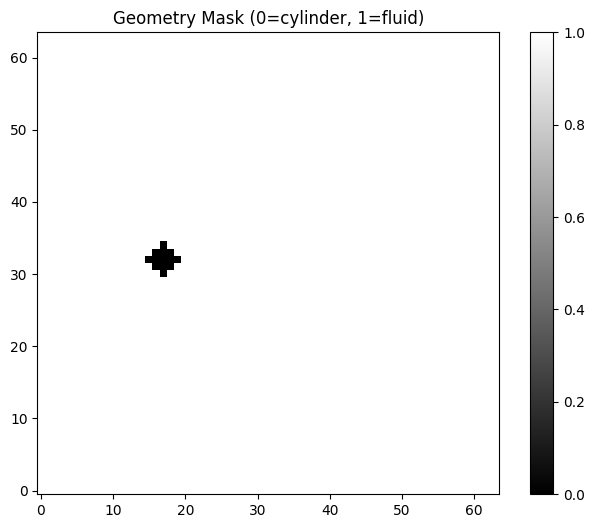

In [40]:
def create_geometry_mask(params: Dict, grid_size: Tuple[int, int] = (64, 64)) -> np.ndarray:
    """
    Create binary mask for cylinder obstacle.
    mask(x) = 1 inside cylinder, 0 elsewhere
    """
    H, W = grid_size
    mask = np.ones((H, W), dtype=np.float32)
    
    # Extract geometry parameters
    radius = params['radius']
    x_min = params['x_min']
    x_max = params['x_max']
    y_min = params['y_min']
    y_max = params['y_max']
    
    # Calculate cylinder center (assuming it's centered in y, positioned at x=0 relative to domain)
    # Domain spans from x_min to x_max, y_min to y_max
    domain_width = x_max - x_min
    domain_height = y_max - y_min
    
    # Cylinder center is at x=0 (relative to x_min), y=0 (center of domain)
    center_x_rel = 0.0 - x_min  # Relative to domain start
    center_y_rel = (y_max + y_min) / 2 - y_min  # Center of domain
    
    # Convert to grid coordinates
    center_x_grid = int((center_x_rel / domain_width) * W)
    center_y_grid = int((center_y_rel / domain_height) * H)
    radius_grid = int((radius / domain_width) * W)
    
    # Create coordinate grids
    y_coords, x_coords = np.ogrid[:H, :W]
    
    # Distance from center
    dist_from_center = np.sqrt((x_coords - center_x_grid)**2 + (y_coords - center_y_grid)**2)
    
    # Set mask to 0 inside cylinder
    mask[dist_from_center <= radius_grid] = 0.0
    
    return mask

# Test mask generation
test_mask = create_geometry_mask(all_params[0])
print(f"Mask shape: {test_mask.shape}")
print(f"Mask values: min={test_mask.min()}, max={test_mask.max()}, mean={test_mask.mean()}")
plt.figure(figsize=(8, 6))
plt.imshow(test_mask, cmap='gray', origin='lower')
plt.title('Geometry Mask (0=cylinder, 1=fluid)')
plt.colorbar()
plt.show()


## 3. FNO Architecture Implementation

Implement Fourier Neural Operator according to roadmap specifications.


In [ ]:
class SpectralConv2d(nn.Module):
    """2D Spectral Convolution Layer
    
    Hybrid MPS/CPU implementation: Uses MPS for most ops, CPU for FFT.
    Falls back to manual CPU transfer if PYTORCH_ENABLE_MPS_FALLBACK doesn't work.
    """
    def __init__(self, in_channels: int, out_channels: int, modes1: int, modes2: int):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply
        self.modes2 = modes2
        
        # Complex weights - keep on CPU (MPS doesn't support complex operations)
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 
                                   dtype=torch.cfloat, device=torch.device('cpu'))
        )
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 
                                   dtype=torch.cfloat, device=torch.device('cpu'))
        )
    
    def forward(self, x):
        """
        Forward pass with hybrid MPS/CPU:
        All complex operations (FFT, einsum) happen on CPU
        """
        batchsize = x.shape[0]
        original_device = x.device
        
        # CRITICAL: Move to CPU for ALL complex operations
        # MPS doesn't support FFT or complex einsum operations
        if original_device.type == 'mps':
            x_cpu = x.to('cpu', non_blocking=False)
        else:
            x_cpu = x
        
        # Compute Fourier coefficients on CPU
        x_ft = torch.fft.rfft2(x_cpu)
        
        # Ensure weights are on CPU (they should be, but double-check)
        weights1_cpu = self.weights1.to('cpu')
        weights2_cpu = self.weights2.to('cpu')
        
        # Multiply relevant Fourier modes (ALL on CPU - einsum with complex needs CPU)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, 
                            dtype=torch.cfloat, device='cpu')
        
        # Einsum operations must be on CPU (MPS doesn't support complex einsum)
        # x_ft is already on CPU, weights are on CPU, so einsum will be on CPU
        out_ft[:, :, :self.modes1, :self.modes2] = \
            torch.einsum("bixy,ioxy->boxy", 
                        x_ft[:, :, :self.modes1, :self.modes2], 
                        weights1_cpu)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            torch.einsum("bixy,ioxy->boxy", 
                        x_ft[:, :, -self.modes1:, :self.modes2], 
                        weights2_cpu)
        
        # Return to physical space on CPU
        x_out = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        
        # Move back to original device (MPS) for subsequent operations
        if original_device.type == 'mps':
            x_out = x_out.to(original_device, non_blocking=True)
        
        return x_out


class FNOBlock(nn.Module):
    """FNO Block: Spectral Convolution + Pointwise Convolution"""
    def __init__(self, width: int, modes1: int, modes2: int):
        super(FNOBlock, self).__init__()
        self.conv = SpectralConv2d(width, width, modes1, modes2)
        self.w = nn.Conv2d(width, width, 1)  # Pointwise convolution
        self.activation = nn.GELU()
        self.norm = nn.InstanceNorm2d(width)
    
    def forward(self, x):
        return self.norm(self.activation(self.conv(x) + self.w(x)))


class FNO(nn.Module):
    """
    Fourier Neural Operator for 2D Navier-Stokes time evolution
    
    Input channels: [u_x^t, u_y^t, u_B, ρ, μ, d, x1, x2, y1, y2, mask] = 11 channels
    Output channels: [u_x^{t+1}, u_y^{t+1}] = 2 channels
    """
    def __init__(
        self,
        in_channels: int = 11,
        out_channels: int = 2,
        width: int = 64,
        modes1: int = 16,
        modes2: int = 16,
        n_layers: int = 4,
        padding: int = 20  # Zero padding for boundary conditions
    ):
        super(FNO, self).__init__()
        self.padding = padding
        
        # Lifting layer: project to higher dimension
        self.fc0 = nn.Linear(in_channels, width)
        
        # Fourier layers (FFT device is handled internally in SpectralConv2d)
        self.fno_blocks = nn.ModuleList([
            FNOBlock(width, modes1, modes2) for _ in range(n_layers)
        ])
        
        # Projection layer: back to output dimension
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, out_channels)
        self.activation = nn.GELU()
    
    def forward(self, x):
        """
        x: [B, H, W, in_channels]
        Returns: [B, H, W, out_channels]
        """
        # Zero padding for boundary conditions (Option A from roadmap)
        if self.padding > 0:
            x = torch.nn.functional.pad(x, (0, 0, self.padding, self.padding, self.padding, self.padding), mode='constant', value=0)
        
        # Convert to [B, in_channels, H, W] for conv layers
        x = x.permute(0, 3, 1, 2)
        
        # Lifting
        x = x.permute(0, 2, 3, 1)  # [B, H, W, in_channels]
        x = self.fc0(x)  # [B, H, W, width]
        x = x.permute(0, 3, 1, 2)  # [B, width, H, W]
        
        # Fourier layers
        for fno_block in self.fno_blocks:
            x = fno_block(x)
        
        # Projection
        x = x.permute(0, 2, 3, 1)  # [B, H, W, width]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)  # [B, H, W, out_channels]
        
        # Crop back to original size
        if self.padding > 0:
            x = x[:, self.padding:-self.padding, self.padding:-self.padding, :]
        
        return x

# Test FNO architecture
# Hybrid: Model on MPS, FFT on CPU automatically
test_model = FNO(in_channels=11, out_channels=2, width=64, modes1=16, modes2=16, n_layers=4).to(device)
test_input = torch.randn(2, 64, 64, 11).to(device)
test_output = test_model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in test_model.parameters()):,}")
print(f"Model device: {next(test_model.parameters()).device}")
print(f"Output device: {test_output.device}")


RuntimeError: MPS device does not support bmm for non-float inputs

In [ ]:
def prepare_input_channels(u_t: np.ndarray, v_t: np.ndarray, params: Dict, mask: np.ndarray) -> np.ndarray:
    """
    Create input tensor with 11 channels:
    [u_x^t, u_y^t, u_B, ρ, μ, d, x1, x2, y1, y2, mask]
    """
    H, W = u_t.shape[-2], u_t.shape[-1]
    
    # Broadcast scalar parameters to spatial dimensions
    u_B = np.full((H, W), params['vel_in'], dtype=np.float32)
    rho = np.full((H, W), params['density'], dtype=np.float32)
    mu = np.full((H, W), params['viscosity'], dtype=np.float32)
    d = np.full((H, W), params['radius'] * 2, dtype=np.float32)  # diameter
    x1 = np.full((H, W), params['x_min'], dtype=np.float32)
    x2 = np.full((H, W), params['x_max'], dtype=np.float32)
    y1 = np.full((H, W), params['y_min'], dtype=np.float32)
    y2 = np.full((H, W), params['y_max'], dtype=np.float32)
    
    # Stack channels: [u_x, u_y, u_B, ρ, μ, d, x1, x2, y1, y2, mask]
    input_channels = np.stack([
        u_t, v_t, u_B, rho, mu, d, x1, x2, y1, y2, mask
    ], axis=-1)  # Shape: (H, W, 11)
    
    return input_channels


from torch.utils.data import Dataset

class CylinderFlowDataset(Dataset):
    """
    Lazy-loading dataset that generates samples on-the-fly instead of pre-loading everything.
    This prevents memory issues with large datasets.
    """
    def __init__(self, u_data_list: List[np.ndarray], v_data_list: List[np.ndarray],
                 params_list: List[Dict], masks_list: List[np.ndarray], 
                 rollout_steps: int = 5):
        self.u_data_list = u_data_list
        self.v_data_list = v_data_list
        self.params_list = params_list
        self.masks_list = masks_list
        self.rollout_steps = rollout_steps
        
        # Pre-compute indices for efficient access
        self.indices = []
        for case_idx, (u_data, v_data) in enumerate(zip(u_data_list, v_data_list)):
            T = u_data.shape[0]
            for t in range(T - rollout_steps):
                self.indices.append((case_idx, t))
        
        print(f"Dataset created with {len(self.indices)} samples from {len(u_data_list)} cases")
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        case_idx, t = self.indices[idx]
        
        # Get data for this case
        u_data = self.u_data_list[case_idx]
        v_data = self.v_data_list[case_idx]
        params = self.params_list[case_idx]
        mask = self.masks_list[case_idx]
        
        # Current state
        u_t = u_data[t]
        v_t = v_data[t]
        
        # Prepare input
        input_channels = prepare_input_channels(u_t, v_t, params, mask)
        
        # Target: future states (K steps ahead)
        target_u = u_data[t+1:t+self.rollout_steps+1]  # Shape: (K, H, W)
        target_v = v_data[t+1:t+self.rollout_steps+1]  # Shape: (K, H, W)
        target = np.stack([target_u, target_v], axis=-1)  # Shape: (K, H, W, 2)
        
        # Convert to tensors
        input_tensor = torch.FloatTensor(input_channels)
        target_tensor = torch.FloatTensor(target)
        
        return input_tensor, target_tensor

# Create masks for all cases
masks_list = [create_geometry_mask(params) for params in all_params]

# Create lazy-loading dataset (doesn't load all data into memory)
print("Creating dataset (lazy-loading)...")
full_dataset = CylinderFlowDataset(all_u_data, all_v_data, all_params, masks_list, rollout_steps=5)
print(f"Total samples: {len(full_dataset)}")

# Get a small sample to compute statistics (for normalization if needed)
sample_input, sample_target = full_dataset[0]
print(f"Sample input shape: {sample_input.shape}")
print(f"Sample target shape: {sample_target.shape}")


Creating dataset (lazy-loading)...
Dataset created with 27675 samples from 45 cases
Total samples: 27675
Sample input shape: torch.Size([64, 64, 11])
Sample target shape: torch.Size([5, 64, 64, 2])


## 5. Train/Test Split (70% Training, 30% Evaluation)


In [ ]:
# 70/30 split using indices (more memory efficient)
from torch.utils.data import Subset

# Create indices for train/test split
n_samples = len(full_dataset)
n_train = int(n_samples * 0.7)
indices = np.arange(n_samples)
np.random.seed(42)
np.random.shuffle(indices)

train_indices = indices[:n_train]
eval_indices = indices[n_train:]

# Create subset datasets (still lazy-loading)
train_dataset = Subset(full_dataset, train_indices)
eval_dataset = Subset(full_dataset, eval_indices)

print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")
print("Note: Data is loaded on-the-fly in batches, not all at once")


Training samples: 19372
Evaluation samples: 8303
Note: Data is loaded on-the-fly in batches, not all at once


## 6. Training Code Block

Train FNO with autoregressive K-step rollout loss.


In [ ]:
# Initialize model
# Hybrid approach: Model on MPS, FFT operations manually handled on CPU
model_device = device  # Use MPS if available
print(f"Model device: {model_device}")
print("Note: FFT operations will use CPU (manual transfer for reliability)")

# Create model
model = FNO(in_channels=11, out_channels=2, width=64, modes1=16, modes2=16, n_layers=4, padding=20).to(model_device)

# Ensure complex weights stay on CPU (they're created on CPU, but .to() might move them)
for name, param in model.named_parameters():
    if param.dtype == torch.cfloat:
        param.data = param.data.to('cpu')
        print(f"Ensured {name} is on CPU (complex dtype)")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training parameters
batch_size = 4  # Reduced batch size to speed up per-batch processing
n_epochs = 50
rollout_steps = 3  # K-step rollout (reduced from 5 for faster training - can increase later)
print(f"Using rollout_steps={rollout_steps} (reduced for faster training)")

# Create data loaders (with lazy loading)
# Use pin_memory=True for faster CPU->GPU transfers
from torch.utils.data import DataLoader
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True if model_device.type != 'cpu' else False
)
eval_loader = DataLoader(
    eval_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if model_device.type != 'cpu' else False
)

print(f"Batch size: {batch_size}")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Estimated samples per epoch: {batch_size * len(train_loader)}")

# Training loop
train_losses = []
import time

print("Starting training...")
print(f"Total epochs: {n_epochs}, Batches per epoch: {len(train_loader)}")
print(f"Total batches: {n_epochs * len(train_loader)}")
print("-" * 60)

# Test first batch to ensure everything works
print("Testing first batch...")
first_batch = next(iter(train_loader))
print(f"First batch loaded: inputs shape={first_batch[0].shape}, targets shape={first_batch[1].shape}")
print("Starting training loop...")
print("-" * 60)

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_start_time = time.time()
    
    for batch_idx, (batch_inputs, batch_targets) in enumerate(train_loader):
        # Print first batch to confirm we're processing
        if batch_idx == 0 and epoch == 0:
            print(f"Processing first batch: inputs device={batch_inputs.device}, shape={batch_inputs.shape}")
        batch_start_time = time.time()
        
        # Move batch to model device (MPS/CPU)
        batch_inputs = batch_inputs.to(model_device, non_blocking=True)
        batch_targets = batch_targets.to(model_device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Autoregressive rollout loss
        current_state = batch_inputs  # [B, H, W, 11]
        total_loss = 0.0
        
        # Predict K steps ahead autoregressively
        for k in range(rollout_steps):
            # Predict next step
            pred_next = model(current_state)  # [B, H, W, 2]
            
            # Get target for this step
            target_k = batch_targets[:, k, :, :, :]  # [B, H, W, 2]
            
            # Compute loss (L2 velocity error with energy weighting)
            velocity_error = torch.mean((pred_next - target_k) ** 2)
            
            # Energy-weighted loss (kinetic energy)
            u_pred, v_pred = pred_next[:, :, :, 0], pred_next[:, :, :, 1]
            u_target, v_target = target_k[:, :, :, 0], target_k[:, :, :, 1]
            kinetic_energy_pred = 0.5 * (u_pred**2 + v_pred**2)
            kinetic_energy_target = 0.5 * (u_target**2 + v_target**2)
            energy_error = torch.mean((kinetic_energy_pred - kinetic_energy_target) ** 2)
            
            # Combined loss
            step_loss = velocity_error + 0.1 * energy_error
            total_loss += step_loss
            
            # Update current state for next autoregressive step (in-place update to avoid clone)
            current_state[:, :, :, 0] = pred_next[:, :, :, 0]  # u_x
            current_state[:, :, :, 1] = pred_next[:, :, :, 1]  # u_y
        
        # Average loss over rollout steps
        loss = total_loss / rollout_steps
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            batch_time = time.time() - batch_start_time
            print(f"Epoch [{epoch+1}/{n_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.6f}, Time: {batch_time:.2f}s")
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)
    
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch [{epoch+1}/{n_epochs}] completed - Avg Loss: {avg_loss:.6f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}, Time: {epoch_time:.2f}s")
    print("-" * 60)

print("Training completed!")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.grid(True)
plt.show()


Model device: mps
Note: FFT operations will use CPU (manual transfer for reliability)
Ensured fno_blocks.0.conv.weights1 is on CPU (complex dtype)
Ensured fno_blocks.0.conv.weights2 is on CPU (complex dtype)
Ensured fno_blocks.1.conv.weights1 is on CPU (complex dtype)
Ensured fno_blocks.1.conv.weights2 is on CPU (complex dtype)
Ensured fno_blocks.2.conv.weights1 is on CPU (complex dtype)
Ensured fno_blocks.2.conv.weights2 is on CPU (complex dtype)
Ensured fno_blocks.3.conv.weights1 is on CPU (complex dtype)
Ensured fno_blocks.3.conv.weights2 is on CPU (complex dtype)
Using rollout_steps=3 (reduced for faster training)
Batch size: 4
Batches per epoch: 4843
Estimated samples per epoch: 19372
Starting training...
Total epochs: 50, Batches per epoch: 4843
Total batches: 242150
------------------------------------------------------------
Testing first batch...
First batch loaded: inputs shape=torch.Size([4, 64, 64, 11]), targets shape=torch.Size([4, 5, 64, 64, 2])
Starting training loop...


KeyboardInterrupt: 

## 7. Evaluation Code Block

Evaluate model on test set with long-horizon stability metrics.


In [ ]:
# Evaluation metrics
def compute_metrics(pred: torch.Tensor, target: torch.Tensor) -> Dict[str, float]:
    """Compute evaluation metrics"""
    # L2 velocity error
    l2_error = torch.mean((pred - target) ** 2).item()
    
    # Kinetic energy drift
    u_pred, v_pred = pred[:, :, :, 0], pred[:, :, :, 1]
    u_target, v_target = target[:, :, :, 0], target[:, :, :, 1]
    
    ke_pred = 0.5 * (u_pred**2 + v_pred**2)
    ke_target = 0.5 * (u_target**2 + v_target**2)
    ke_drift = torch.mean(torch.abs(ke_pred - ke_target)).item()
    
    # Relative error
    relative_error = torch.mean(torch.abs(pred - target) / (torch.abs(target) + 1e-6)).item()
    
    return {
        'l2_error': l2_error,
        'ke_drift': ke_drift,
        'relative_error': relative_error
    }

# Evaluation loop
model.eval()
eval_losses = []
all_metrics = {'l2_error': [], 'ke_drift': [], 'relative_error': []}

print("Starting evaluation...")
with torch.no_grad():
    for batch_inputs, batch_targets in eval_loader:
        # Move batch to model device (CPU for FNO)
        batch_inputs = batch_inputs.to(model_device)
        batch_targets = batch_targets.to(model_device)
        current_state = batch_inputs
        batch_metrics = {'l2_error': 0.0, 'ke_drift': 0.0, 'relative_error': 0.0}
        
        # Autoregressive prediction for K steps
        for k in range(rollout_steps):
            pred_next = model(current_state)
            target_k = batch_targets[:, k, :, :, :]
            
            # Compute metrics
            metrics = compute_metrics(pred_next, target_k)
            for key in batch_metrics:
                batch_metrics[key] += metrics[key]
            
            # Update state for next step
            current_state = current_state.clone()
            current_state[:, :, :, 0] = pred_next[:, :, :, 0]
            current_state[:, :, :, 1] = pred_next[:, :, :, 1]
        
        # Average metrics over rollout steps
        for key in batch_metrics:
            batch_metrics[key] /= rollout_steps
            all_metrics[key].append(batch_metrics[key])
        
        # Compute loss
        loss = batch_metrics['l2_error']
        eval_losses.append(loss)

avg_eval_loss = np.mean(eval_losses)
print(f"\nEvaluation Results:")
print(f"Average L2 Error: {avg_eval_loss:.6f}")
print(f"Average Kinetic Energy Drift: {np.mean(all_metrics['ke_drift']):.6f}")
print(f"Average Relative Error: {np.mean(all_metrics['relative_error']):.6f}")

# Plot evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(all_metrics['l2_error'], bins=50)
axes[0].set_xlabel('L2 Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('L2 Velocity Error Distribution')
axes[0].grid(True)

axes[1].hist(all_metrics['ke_drift'], bins=50)
axes[1].set_xlabel('Kinetic Energy Drift')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Kinetic Energy Drift Distribution')
axes[1].grid(True)

axes[2].hist(all_metrics['relative_error'], bins=50)
axes[2].set_xlabel('Relative Error')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Relative Error Distribution')
axes[2].grid(True)

plt.tight_layout()
plt.show()


## 8. Visualization: Predicted vs Ground Truth

Visualize predictions for sample cases.


In [ ]:
# Visualize predictions
model.eval()
with torch.no_grad():
    # Get a sample from evaluation set
    sample_input, sample_target = eval_dataset[0]
    sample_input = sample_input.unsqueeze(0).to(model_device)  # [1, H, W, 11]
    sample_target = sample_target.unsqueeze(0).to(model_device)  # [1, K, H, W, 2]
    
    # Predict autoregressively
    current_state = sample_input
    predictions = []
    
    for k in range(rollout_steps):
        pred_next = model(current_state)
        predictions.append(pred_next[0].cpu().numpy())  # [H, W, 2]
        
        # Update state
        current_state = current_state.clone()
        current_state[0, :, :, 0] = pred_next[0, :, :, 0]
        current_state[0, :, :, 1] = pred_next[0, :, :, 1]
    
    predictions = np.array(predictions)  # [K, H, W, 2]
    targets = sample_target[0].cpu().numpy()  # [K, H, W, 2]
    
    # Plot first and last timestep
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Timestep 0
    axes[0, 0].imshow(predictions[0, :, :, 0], cmap='RdBu_r', origin='lower')
    axes[0, 0].set_title('Predicted u (t+1)')
    axes[0, 0].set_xlabel('X')
    axes[0, 0].set_ylabel('Y')
    
    axes[0, 1].imshow(targets[0, :, :, 0], cmap='RdBu_r', origin='lower')
    axes[0, 1].set_title('Ground Truth u (t+1)')
    
    axes[0, 2].imshow(predictions[0, :, :, 1], cmap='RdBu_r', origin='lower')
    axes[0, 2].set_title('Predicted v (t+1)')
    
    axes[0, 3].imshow(targets[0, :, :, 1], cmap='RdBu_r', origin='lower')
    axes[0, 3].set_title('Ground Truth v (t+1)')
    
    # Last timestep
    last_idx = rollout_steps - 1
    axes[1, 0].imshow(predictions[last_idx, :, :, 0], cmap='RdBu_r', origin='lower')
    axes[1, 0].set_title(f'Predicted u (t+{rollout_steps})')
    
    axes[1, 1].imshow(targets[last_idx, :, :, 0], cmap='RdBu_r', origin='lower')
    axes[1, 1].set_title(f'Ground Truth u (t+{rollout_steps})')
    
    axes[1, 2].imshow(predictions[last_idx, :, :, 1], cmap='RdBu_r', origin='lower')
    axes[1, 2].set_title(f'Predicted v (t+{rollout_steps})')
    
    axes[1, 3].imshow(targets[last_idx, :, :, 1], cmap='RdBu_r', origin='lower')
    axes[1, 3].set_title(f'Ground Truth v (t+{rollout_steps})')
    
    plt.tight_layout()
    plt.show()
    
    # Compute error maps
    error_u = np.abs(predictions - targets)[:, :, :, 0]
    error_v = np.abs(predictions - targets)[:, :, :, 1]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    im1 = axes[0].imshow(error_u[-1], cmap='hot', origin='lower')
    axes[0].set_title(f'Error in u (t+{rollout_steps})')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(error_v[-1], cmap='hot', origin='lower')
    axes[1].set_title(f'Error in v (t+{rollout_steps})')
    plt.colorbar(im2, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

print("Evaluation and visualization completed!")
